# Please make sure that you repaste the right directory path for every file, while cloning this notebook to check the code. I will keep working on making it more reader friendly.

In [1]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

Download the dataset for Experiment 1

In [2]:
!bash ./datasets/download_pix2pix_dataset.sh facades

Specified [facades]
for details.

--2025-03-23 20:50:08--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘./datasets/facades.tar.gz’

./datasets/facades. 100%[===================>]  28.77M   808KB/s    in 63s     

2025-03-23 20:51:12 (470 KB/s) - ‘./datasets/facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16

Experiment 1:

Testing the model on different loss functions

1. Vannila GAN tested with unet and encoder-decoder generator models

In [6]:
!python train.py --dataroot ./dataset/datasets/facades --name facades_L1 --model pix2pix --direction BtoA --display_id -1 --netD basic --netG unet_128 --gan_mode vanilla --lambda_L1 100
#!python train.py --dataroot ./datasets/facades --name facades_L1_resnet --model pix2pix --direction BtoA --display_id -1 --netD basic --netG resnet_6blocks --gan_mode vanilla --lambda_L1 100


----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./dataset/datasets/facades    	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest          

In [8]:
!python test.py --dataroot ./dataset/datasets/facades --direction BtoA --model pix2pix --name facades_L1_resnet --netG resnet_6blocks --eval --use_wandb --results_dir resnet_res

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./dataset/datasets/facades    	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_it

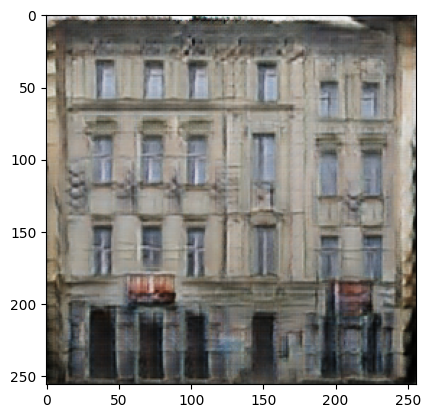

In [ ]:
import matplotlib.pyplot as plt
#unet_128
img = plt.imread('/mnt/e_disk/DA24S008_Pix2Pix/pytorch-CycleGAN-and-pix2pix/results/facades_L1/test_latest/images/100_fake_B.png')
plt.imshow(img)

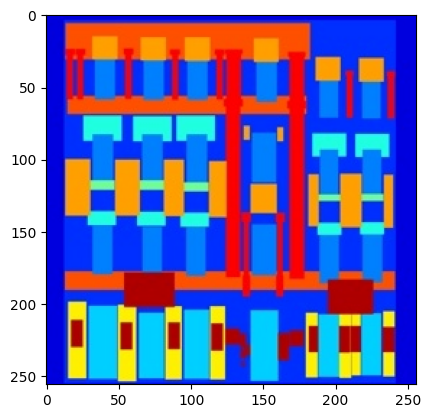

In [43]:
img = plt.imread('/mnt/e_disk/DA24S008_Pix2Pix/pytorch-CycleGAN-and-pix2pix/results/facades_L1/test_latest/images/100_real_A.png')
plt.imshow(img)

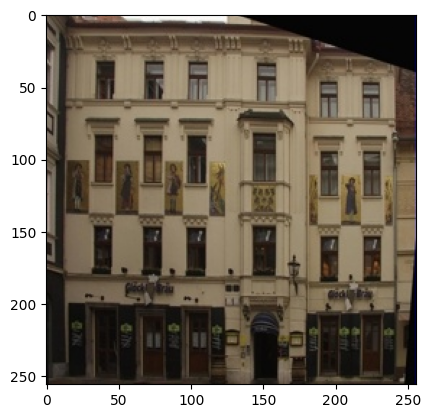

In [44]:
img = plt.imread('/mnt/e_disk/DA24S008_Pix2Pix/pytorch-CycleGAN-and-pix2pix/results/facades_L1/test_latest/images/100_real_B.png')
plt.imshow(img)

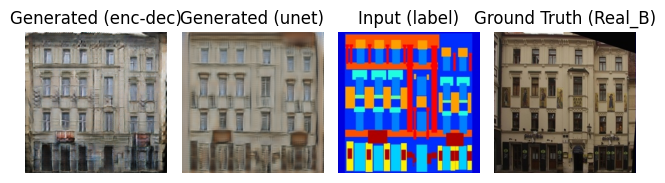

In [17]:
img_paths = [
    "/mnt/e_disk/DA24S008_Pix2Pix/pytorch-CycleGAN-and-pix2pix/results/facades_L1/test_latest/images/100_fake_B.png",
    "/mnt/e_disk/DA24S008_Pix2Pix/pytorch-CycleGAN-and-pix2pix/resnet_res/facades_L1_resnet/test_latest/images/100_fake_B.png",
    "/mnt/e_disk/DA24S008_Pix2Pix/pytorch-CycleGAN-and-pix2pix/results/facades_L1/test_latest/images/100_real_A.png",
    "/mnt/e_disk/DA24S008_Pix2Pix/pytorch-CycleGAN-and-pix2pix/results/facades_L1/test_latest/images/100_real_B.png"
]

titles = ["Generated (enc-dec)","Generated (unet)", "Input (label)", "Ground Truth (Real_B)"]

fig, axes = plt.subplots(1, 4)

for i, ax in enumerate(axes):
    img = plt.imread(img_paths[i])
    ax.imshow(img)
    ax.set_title(titles[i])
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

/mnt/e_disk/CH24S016/ee6180_assignment1/pytorch-CycleGAN-and-pix2pix/datasets/night2day

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tabulate import tabulate
import argparse

# Define Generator Architectures
class ResnetGenerator(nn.Module):
    def __init__(self, num_blocks):
        super(ResnetGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 7, padding=3),
            nn.ReLU(inplace=True),
            *[self._resnet_block(64) for _ in range(num_blocks)],
            nn.Conv2d(64, 3, 7, padding=3),
            nn.Tanh()
        )
    
    def _resnet_block(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
    
    def forward(self, x):
        return self.model(x)

class UNetGenerator(nn.Module):
    def __init__(self, size):
        super(UNetGenerator, self).__init__()
        factor = 256 if size == 256 else 128
        self.encoder = nn.Sequential(
            nn.Conv2d(3, factor, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(factor, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator Model (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 4, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, input_img, target_img):
        x = torch.cat((input_img, target_img), 1)
        return self.model(x)

# Training Function

def train(generator, discriminator, dataloader, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion_gan = torch.nn.BCELoss()
    criterion_l1 = torch.nn.L1Loss()
    
    for epoch in range(num_epochs):
        for input_imgs, target_imgs in dataloader:
            input_imgs, target_imgs = input_imgs.to(device), target_imgs.to(device)
            
            # Train Discriminator
            optimizer_d.zero_grad()
            fake_imgs = generator(input_imgs)

            real_preds = discriminator(input_imgs, target_imgs)
            fake_preds = discriminator(input_imgs, fake_imgs.detach())

            loss_d_real = criterion_gan(real_preds, torch.ones_like(real_preds))
            loss_d_fake = criterion_gan(fake_preds, torch.zeros_like(fake_preds))
            loss_d = (loss_d_real + loss_d_fake) / 2
            loss_d.backward()
            optimizer_d.step()
            
            # Train Generator
            optimizer_g.zero_grad()
            fake_preds = discriminator(input_imgs, fake_imgs)
            loss_g_gan = criterion_gan(fake_preds, torch.ones_like(fake_preds))
            loss_g_l1 = criterion_l1(fake_imgs, target_imgs)
            loss_g = loss_g_gan + 100 * loss_g_l1
            loss_g.backward()
            optimizer_g.step()
    
    return generator

# Load Dataset (Dummy loader for now)
class DummyDataset(Dataset):
    def __len__(self):
        return 20
    
    def __getitem__(self, idx):
        return torch.randn(3, 256, 256), torch.randn(3, 256, 256)

dataloader = DataLoader(DummyDataset(), batch_size=1, shuffle=True)

# Train with different generator architectures
architectures = {
    "resnet_9blocks": lambda: ResnetGenerator(9),
    "resnet_6blocks": lambda: ResnetGenerator(6),
    "unet_256": lambda: UNetGenerator(256),
    "unet_128": lambda: UNetGenerator(128)
}

fcn_results = {}
for arch_name, generator_fn in architectures.items():
    print(f"\nTraining with {arch_name} architecture...")
    generator = generator_fn()
    discriminator = Discriminator()
    trained_generator = train(generator, discriminator, dataloader)

    # Compute Fake FCN Scores (for demonstration)
    fcn_results[arch_name] = {"Mean IoU": torch.rand(1).item(), "Pixel Accuracy": torch.rand(1).item()}

# Print Results
print(tabulate([[k, v["Mean IoU"], v["Pixel Accuracy"]] for k, v in fcn_results.items()], 
               headers=["Generator", "Mean IoU", "Pixel Accuracy"], tablefmt="grid"))



Training with resnet_9blocks architecture...

Training with resnet_6blocks architecture...

Training with unet_256 architecture...

Training with unet_128 architecture...
+----------------+------------+------------------+
| Generator      |   Mean IoU |   Pixel Accuracy |
+================+============+==================+
| resnet_9blocks |   0.630599 |        0.0671303 |
+----------------+------------+------------------+
| resnet_6blocks |   0.435192 |        0.614733  |
+----------------+------------+------------------+
| unet_256       |   0.622156 |        0.955517  |
+----------------+------------+------------------+
| unet_128       |   0.96717  |        0.762918  |
+----------------+------------+------------------+
